# Position Sensitivity in the NR Spectra of Photoneutron Analysis

I have condensed the data from `0x0004` version of the simulation to see if it matters what x-y position the detector is at. For example z14 and z5 only differ by x-y position, the vertical (z) distance between them and the source is the same. 

In [1]:
import numpy as np
import pandas as pd

In [2]:
#play around with some hits data stored in h5 file
#===============to suppress h5py warning see:
#https://github.com/h5py/h5py/issues/961
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
warnings.resetwarnings()
fz14_sbbe = h5py.File("/data/chocula/villaa/PhotoN_SuperSim/ZipSum/sbbe_z14_190412_0x0004_1-3B.h5","r")
fz5_sbbe = h5py.File("/data/chocula/villaa/PhotoN_SuperSim/ZipSum/sbbe_z5_190412_0x0004_1-3B.h5","r")

#for i in fz14_ybe['simdata/']:
#    print(i)

#for i in fz5_ybe['simdata/']:
#    print(i)

print(list(fz5_sbbe['simdata/'].keys()))

['ERYield', 'ERedep', 'ERhit', 'ERt', 'ERx', 'ERy', 'ERz', 'NRYield', 'NRedep', 'NRhit', 'NRt', 'NRx', 'NRy', 'NRz', 'cERcapProg', 'cNRcapProg', 'cap_KE', 'cap_Time', 'cap_X', 'cap_Xmom', 'cap_Y', 'cap_Ymom', 'cap_Z', 'cap_Zmom', 'ncap', 'nprim', 'prim_KE', 'prim_PType', 'prim_X', 'prim_Xmom', 'prim_Y', 'prim_Ymom', 'prim_Z', 'prim_Zmom', 'totalevents']


In [3]:
sbbe_z14 = {}
sbbe_z14['NRhit'] = np.asarray(fz14_sbbe['simdata/NRhit'],dtype=np.float64())
sbbe_z14['ERhit'] = np.asarray(fz14_sbbe['simdata/ERhit'],dtype=np.float64())
sbbe_z14['NRedep'] = np.asarray(fz14_sbbe['simdata/NRedep'],dtype=np.float64())

sbbe_z5 = {}
sbbe_z5['NRhit'] = np.asarray(fz5_sbbe['simdata/NRhit'],dtype=np.float64())
sbbe_z5['ERhit'] = np.asarray(fz5_sbbe['simdata/ERhit'],dtype=np.float64())
sbbe_z5['NRedep'] = np.asarray(fz5_sbbe['simdata/NRedep'],dtype=np.float64())

In [4]:
#cuts
sbbe_z14['cNR'] = (sbbe_z14['ERhit']==0) & (sbbe_z14['NRhit']>0)
sbbe_z5['cNR'] = (sbbe_z5['ERhit']==0) & (sbbe_z5['NRhit']>0)

In [5]:
#do some yield calculations
import lindhard as lind
#import numpy as np

y = lind.getLindhardGe(False)

yv = np.vectorize(y)

#voltage and average energy per pair
V=70 #should be derived from input structure
egam = 3.3 #eV per pair

sbbe_z14['NRedep_ee'] = sbbe_z14['NRedep']*yv(sbbe_z14['NRedep'])
sbbe_z14['NRedep_t'] = sbbe_z14['NRedep'] + (V/egam)*sbbe_z14['NRedep_ee']
sbbe_z14['edepNR_t'] = np.sum(sbbe_z14['NRedep_t'],1)
sbbe_z14['edepNR_ee'] = sbbe_z14['edepNR_t']/(1+(V/egam)) #electron-equivalent scale for application of res


sbbe_z5['NRedep_ee'] = sbbe_z5['NRedep']*yv(sbbe_z5['NRedep'])
sbbe_z5['NRedep_t'] = sbbe_z5['NRedep'] + (V/egam)*sbbe_z5['NRedep_ee']
sbbe_z5['edepNR_t'] = np.sum(sbbe_z5['NRedep_t'],1)
sbbe_z5['edepNR_ee'] = sbbe_z5['edepNR_t']/(1+(V/egam)) #electron-equivalent scale for application of res

In [6]:
#add in the resolution from a model
import pnRes as pnr

r = pnr.getRes('z14') #select the default mode for the resolution model by not specifying second param
rv =  np.vectorize(r)

#apply the res
sbbe_z14['edepNR_ee_res'] = sbbe_z14['edepNR_ee'] + np.random.normal(0,rv(sbbe_z14['edepNR_ee']))
sbbe_z14['edepNR_t_res'] = (1+(V/egam))*sbbe_z14['edepNR_ee_res']  #convert back to eVt if desired
print(np.shape(sbbe_z14['edepNR_t_res']))

sbbe_z5['edepNR_ee_res'] = sbbe_z5['edepNR_ee'] + np.random.normal(0,rv(sbbe_z5['edepNR_ee']))
sbbe_z5['edepNR_t_res'] = (1+(V/egam))*sbbe_z5['edepNR_ee_res']  #convert back to eVt if desired
print(np.shape(sbbe_z5['edepNR_t_res']))

(754037,)
(740207,)


In [7]:
#make the histogram

emax = 20000 #keVt scale
#make the new capture histogram
sbbe_z14['n_res'],sbbe_z14['nx_res'] = np.histogram(sbbe_z14['edepNR_t_res'][(sbbe_z14['cNR'])]/1000.0,100,range=(0,emax/1000.0)) #do it in keV

sbbe_z14['xc_res'] = (sbbe_z14['nx_res'][:-1] + sbbe_z14['nx_res'][1:]) / 2

sbbe_z5['n_res'],sbbe_z5['nx_res'] = np.histogram(sbbe_z5['edepNR_t_res'][(sbbe_z5['cNR'])]/1000.0,100,range=(0,emax/1000.0)) #do it in keV

sbbe_z5['xc_res'] = (sbbe_z5['nx_res'][:-1] + sbbe_z5['nx_res'][1:]) / 2

In [8]:
#set up a plot 
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

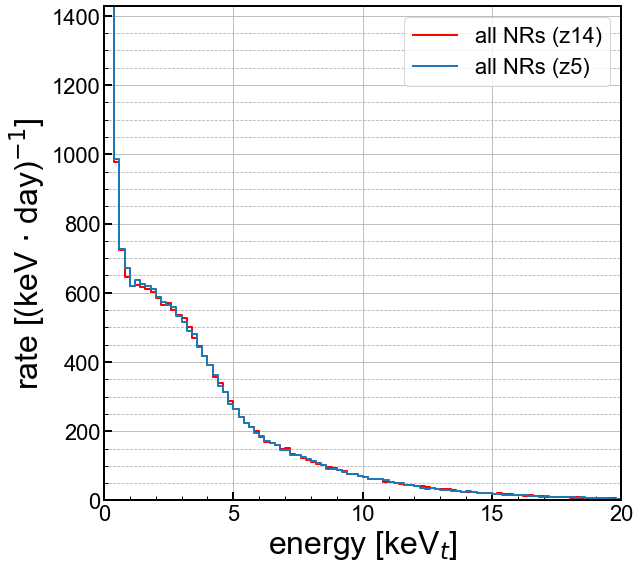

In [9]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

#lay out the colors
rgb_r = (255/255.0,0/255.0,0/255.0)
rgb_b = (0/255.0,0/255.0,255/255.0)
rgb_o = (255/255.0,127/255.0,0/255.0)
rgb_b = (31/255.0,120/255.0,180/255.0)
rgb_lr = (251/255.0,154/255.0,153/255.0)
rgb_g = (203/255.0,195/255.0,195/255.0)

#try a normalization; assume exactly 1e5 gammas per neutron and a 1mCi sourcea
norm = 1/np.float(np.asarray(fz14_sbbe['simdata/totalevents'])) #per neutron
#print(norm)
width = sbbe_z14['xc_res'][1]-sbbe_z14['xc_res'][0] #width in keV
#print(width)
norm = norm/width #per neutron per keV
#print(norm)
srcrate = 3.7e7/1.0e5 #n per second
srcrate = srcrate*(24*60*60) #n per day
norm = norm*srcrate
#print(norm)

#ax1.errorbar(xc, n, yerr=nerr,marker='o', markersize=8, linestyle='none',color='k', label='data')
nrlabel='all NRs ({})'.format('z14')
ax1.step(sbbe_z14['xc_res'],sbbe_z14['n_res']*norm, where='mid',color=rgb_r, linestyle='-', label=nrlabel, linewidth=2)
nrlabel='all NRs ({})'.format('z5')
ax1.step(sbbe_z5['xc_res'],sbbe_z5['n_res']*norm, where='mid',color=rgb_b, linestyle='-', label=nrlabel, linewidth=2)

ymin = 1e1*norm
ymax = 2.5e4*norm

#thresh_t = data[zip][set]['CDMSlite']['thresh_t']
#sigthr_t = data[zip][set]['CDMSlite']['sigthr_t']
#thresh_t/=1000.0
#sigthr_t/=1000.0
#a = [thresh_t,thresh_t] #this was the threshold for IT5Z2 :
#http://titus.stanford.edu/cdms_restricted/Soudan/R133/ebook/171012_AS/T5Z2liteTrigEff.html
#b = [ymin,ymax]

#ax1.plot(a,b,linestyle='--',color='k',label='_nolegend_')
#ax1.plot(a,b,linestyle='--',color='k',label='Thresh. (IT5Z2) in keV$_{\mathrm{nr}}$')

#tlabel = 'Thresh. {0}, keV$_{{\mathrm{{t}}}}$'.format(data[zip]['detname'])
#ax1.axvline(thresh_t, color='k', linestyle='--', lw=2, alpha=0.8,label=tlabel)
#erange_x = np.arange(thresh_t-sigthr_t, thresh_t+sigthr_t, 0.01)
#ax1.fill_between(erange_x, ymin, ymax, facecolor=rgb_o, alpha=0.3)

ax1.set_yscale('linear')
ax1.set_xlim(0, emax/1000.0) #in keV
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('energy [keV$_t$]',**axis_font)
ax1.set_ylabel('rate [(keV $\\cdot$ day)$^{-1}$]',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
#ax1.legend([gh,gl,nh,nl], ['gamma (high gain)','gamma (low gain)','neutron (high gain)', 'neutron (low gain)'],loc=1)
#ax1.legend(loc=1, bbox_to_anchor=(0.82, 1),
#         fancybox=True, shadow=True, ncol=4)
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/IT5Z2_RealSimcaptures_100M.eps')
plt.savefig('figures/sbbe_poscompare_z5-z14.png')
plt.show()